In [1]:
def visualize_samples_with_boxes(hdf5_path, num_samples=5):
    """
    Plots random samples that HAVE fractures, along with their
    bounding boxes, directly from the HDF5 file.
    """
    print(f"Loading samples from {hdf5_path}...")
    
    with h5py.File(hdf5_path, 'r') as hf:
        # 1. Load all labels and find the ones with fractures
        all_labels = hf['labels'][:]
        positive_indices = np.where(all_labels == 1)[0]
        
        if len(positive_indices) == 0:
            print("Error: No positive samples found in the dataset.")
            return
            
        print(f"Found {len(positive_indices)} positive samples.")

        # 2. Pick N random samples from the positive-only list
        if num_samples > len(positive_indices):
            print(f"Warning: Requested {num_samples} but only {len(positive_indices)} are available.")
            num_samples = len(positive_indices)
            
        sample_indices = random.sample(list(positive_indices), num_samples)
        
        # 3. Create a plot for each sample
        # Make the plot wider to see details
        fig, axes = plt.subplots(num_samples, 1, figsize=(10, num_samples * 10))
        if num_samples == 1:
            axes = [axes] # Make it iterable if there's only one

        for ax, idx in zip(axes, sample_indices):
            # Load the data for this one sample
            image = hf['images'][idx]
            bboxes = hf['bboxes'][idx]
            uid = hf['StudyInstanceUID'][idx]
            slice_num = hf['SliceNumber'][idx]
            
            # Filter out the "-1" padding on the bounding boxes
            bboxes = [box for box in bboxes if box[0] != -1.0]
            
            # Plot the image
            ax.imshow(image, cmap='bone')
            ax.set_title(f"UID: {uid}\nSlice: {slice_num} (Index: {idx})")
            
            # Plot each bounding box
            for box in bboxes:
                # bboxes are in [x, y, w, h] format
                x, y, w, h = box
                
                # Create a Rectangle patch
                rect = patches.Rectangle(
                    (x, y), w, h,
                    linewidth=2,
                    edgecolor='r',
                    facecolor='none' # Transparent face
                )
                
                # Add the patch to the Axes
                ax.add_patch(rect)
                
        plt.tight_layout()
        plt.show()

In [2]:
## This script was made using Google Gemini AI ##
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import h5py
import numpy as np

class FractureHDF5Dataset(Dataset):
    """
    A PyTorch Dataset to read the pre-processed HDF5 file.
    """
    def __init__(self, hdf5_path, transform=None):
        self.hdf5_path = hdf5_path
        self.transform = transform
        self.hf = None # File handle, left open for speed
        
        # Open the file once just to get the total length
        try:
            with h5py.File(self.hdf5_path, 'r') as f:
                self.length = len(f['labels'])
        except FileNotFoundError:
            print(f"ERROR: HDF5 file not found at {hdf5_path}")
            raise
        except Exception as e:
            print(f"Error opening HDF5 file: {e}")
            raise

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Open the file here if it's not open
        if self.hf is None:
            self.hf = h5py.File(self.hdf5_path, 'r')

        # --- Get Image ---
        # (H, W) -> (1, H, W) for a 1-channel grayscale image
        image = self.hf['images'][idx]
        image = torch.from_numpy(image).float().unsqueeze(0) # (1, 256, 256)
        
        # --- Get Label (for CLASSIFICATION) ---
        label = self.hf['labels'][idx]
        label = torch.tensor(label, dtype=torch.long) # 0 for no fracture, 1 for fracture

        if self.transform:
            image = self.transform(image)

        return image, label

def get_dataloaders(hdf5_path, batch_size, num_workers=2):
    """
    Creates and returns the pre-split train, val, and test DataLoaders.
    
    Args:
        hdf5_path (str): Path to the HDF5 file.
        batch_size (int): Batch size for the DataLoaders.
        num_workers (int): Number of workers for the DataLoaders.
    
    Returns:
        (DataLoader, DataLoader, DataLoader): train_loader, val_loader, test_loader
    """
    
    print("Loading dataset...")
    # Create the full dataset instance
    full_dataset = FractureHDF5Dataset(hdf5_path)
    
    print("Loading pre-defined train/val/test splits...")
    # Load the pre-defined split assignments from the file
    with h5py.File(hdf5_path, 'r') as f:
        splits = f['split'][:] # [:] loads it into memory

    # Get the indices for each split
    train_indices = np.where(splits == 0)[0]
    val_indices = np.where(splits == 1)[0]
    test_indices = np.where(splits == 2)[0]

    print(f"Total samples: {len(splits)}")
    print(f"  Training indices:   {len(train_indices)}")
    print(f"  Validation indices: {len(val_indices)}")
    print(f"  Test indices:       {len(test_indices)}")

    # Create PyTorch Subsets
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    test_dataset = Subset(full_dataset, test_indices)

    # Create the DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True, # Shuffle the training set
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False, # No need to shuffle val
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False, # No need to shuffle test
        num_workers=num_workers,
        pin_memory=True
    )

    print("DataLoaders created successfully.")
    return train_loader, val_loader, test_loader

In [3]:
import os
import random

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import sys

# --- THIS IS THE KEY ---
# Add the dataset's directory to the Python path
# This allows us to import our .py script
DATASET_PATH = "/kaggle/input/rsna-2022-hdf5-subset"
sys.path.append(DATASET_PATH)

# Now we can import our helper function
# from dataloader import get_dataloaders

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import h5py
import numpy as np
import random
import os
# 1. Define the path to your dataset (this is in Cell 2 of your notebook)
DATASET_PATH = "/kaggle/input/rsna-2022-hdf5-subset"
HDF5_FILE_PATH = os.path.join(DATASET_PATH, "fracture_dataset_subset.h5")

Loading samples from /kaggle/input/rsna-2022-hdf5-subset/fracture_dataset_subset.h5...
Found 7217 positive samples.


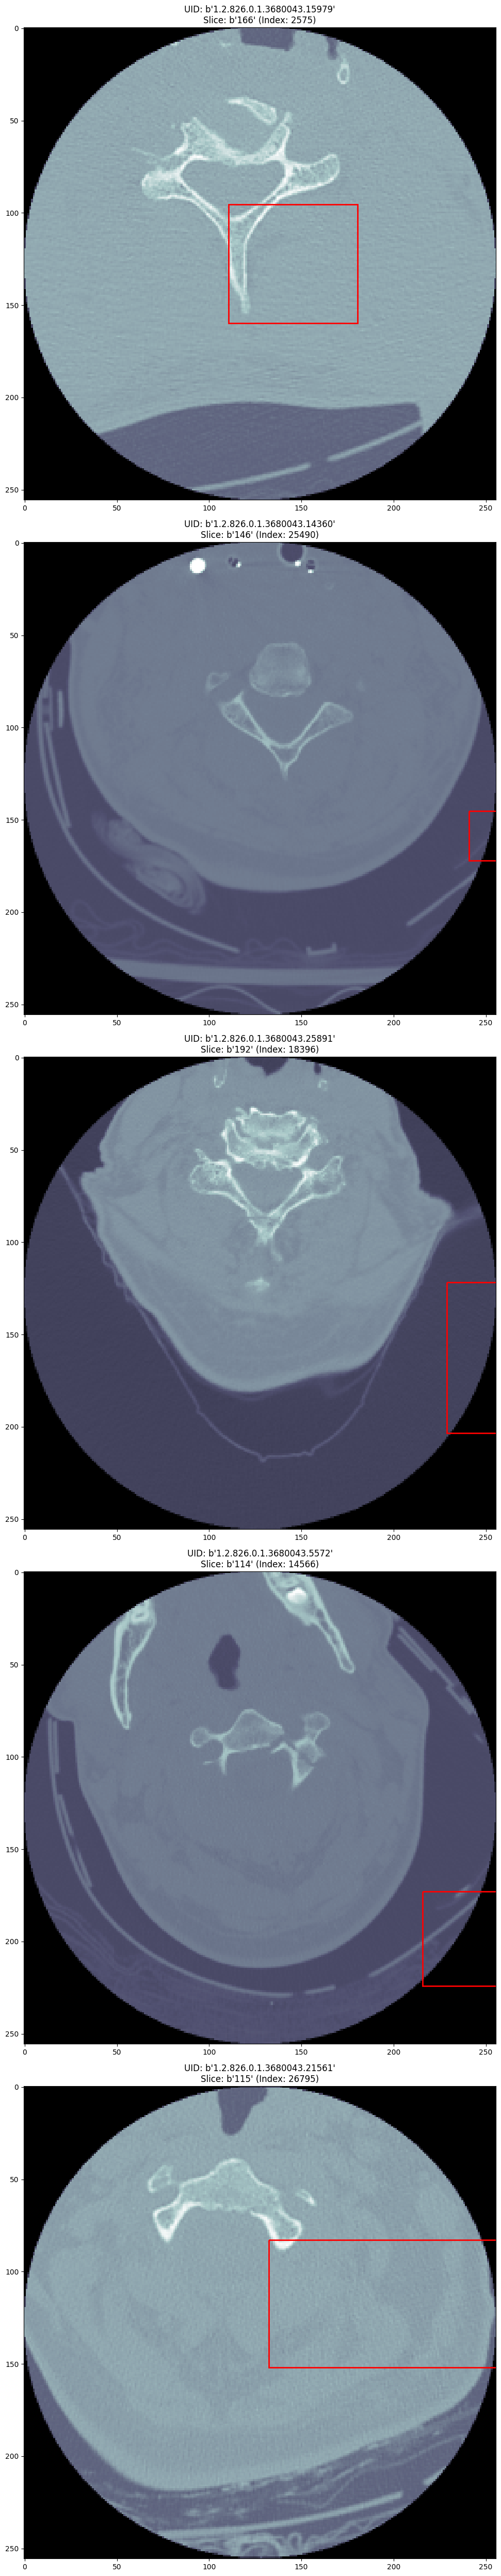

In [11]:




# 2. Run the visualization function
visualize_samples_with_boxes(HDF5_FILE_PATH, num_samples=5)

Loading samples from /kaggle/input/rsna-2022-hdf5-subset/fracture_dataset_subset.h5...
Found 7217 positive samples.


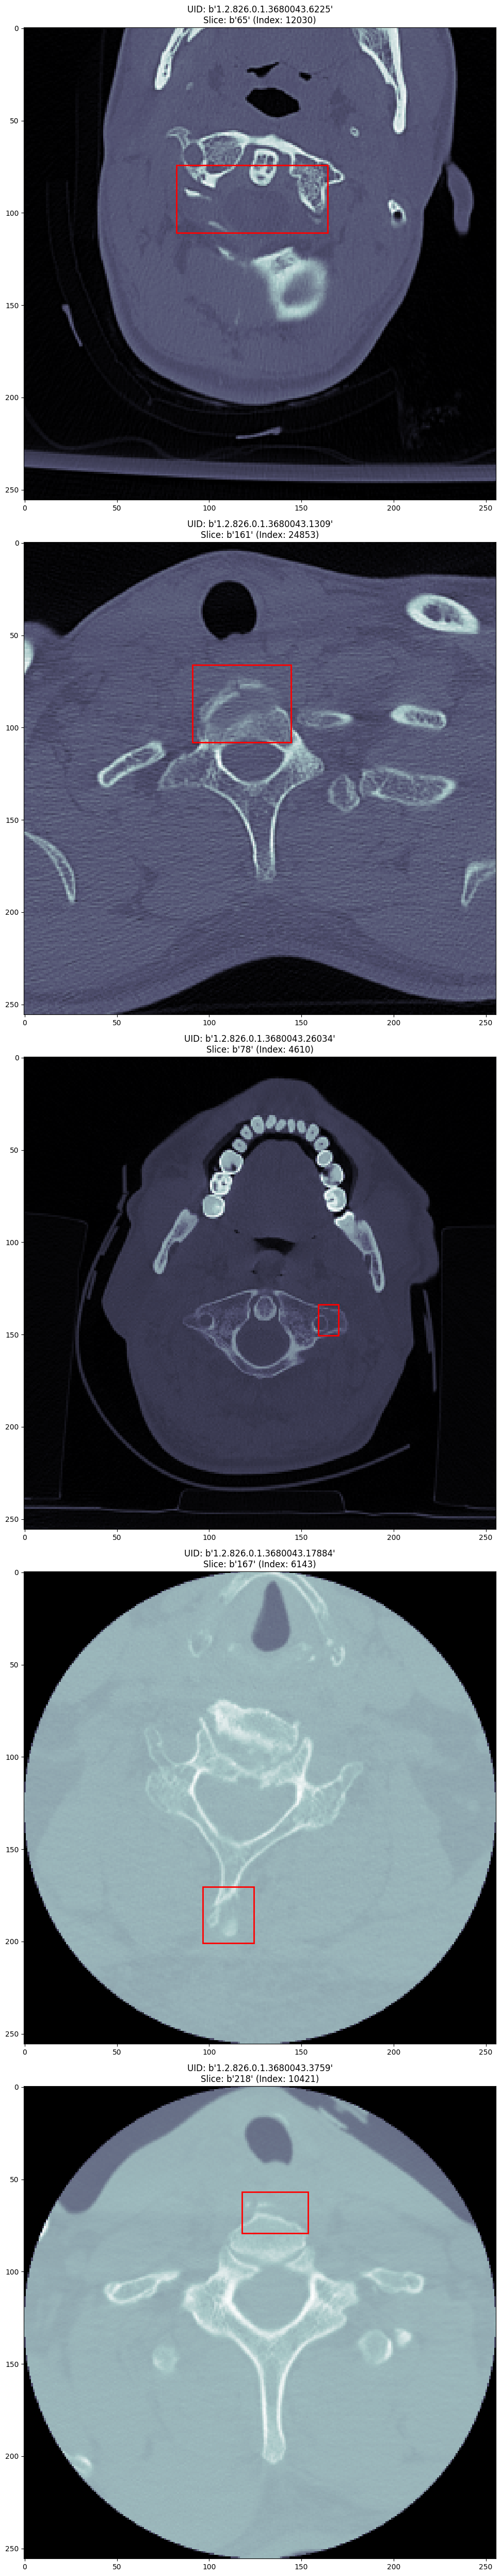

In [6]:




# 2. Run the visualization function
visualize_samples_with_boxes(HDF5_FILE_PATH, num_samples=5)

In [10]:
# --- 1. Load Data ---
BATCH_SIZE = 32
HDF5_FILE_PATH = f"{DATASET_PATH}/fracture_dataset_subset.h5"

train_loader, val_loader, test_loader = get_dataloaders(
    hdf5_path=HDF5_FILE_PATH, 
    batch_size=BATCH_SIZE
)

# --- 2. Define Your Model (Your "From Scratch" Model) ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # ... (rest of your model definition) ...
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.classifier(x)
        return x

Loading dataset...
Loading pre-defined train/val/test splits...
Total samples: 28868
  Training indices:   20207
  Validation indices: 4330
  Test indices:       4331
DataLoaders created successfully.


NameError: name 'nn' is not defined

In [ ]:
# --- 3. Start Training ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    # ... (rest of your training loop) ...
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        images, labels = images.to(device), labels.to(device)
        # ... etc ...
        
    model.eval()
    # ... (rest of your validation loop) ...
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            # ... etc ...

print("\n--- Training Complete ---")